In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.io import json
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

datasetJSONPath = os.getcwd() + "/datasets/empire_psremoting_stager_2020-09-20170827.json"
df = json.read_json(path_or_buf=datasetJSONPath, lines=True)

df.shape

2023-04-06 14:51:55.784937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 14:52:29.849386: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/software/uoa/spack-sw/linux-rhel8-x86_64/gcc-12.1.0/anaconda3-2021.05-g6kymc6js7tc3estviv2s7j4dqo7cant/lib:/opt/slurm/22.05.2-1/lib
2023-04-06 14:52:29.851901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD

(2744, 177)

In [13]:
# functions definition

from collections import Counter
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# Convert integers to strings
def int_to_str(df):
    for column in df.columns:
        # if dtype is int, convert to string , e.g. EventID
        if isinstance(df[column][0], (int, np.int32, np.int64)):
            df[column] = list(map(str, df[column]))
            
    return df
    
# Count NaN in each column in the dataframe
def count_nan(df):
    for column in df.columns:
        num = df[column].isna().sum()
        print(column, str(num))
    return 0

# make a label list of all 0, except the detected threat are 1
def labelList(num, threatIndices):
    y = [0 for x in range(num)]
    for i in threatIndices:
        y[i] =  1
    return y

# Count the items in data frame
def count_items(df):
    for column in df.columns:
        item = df[column]
        print(column, ": ", sorted(Counter(item).items()))
        
    return 0

# replicate specified data to the end of the dataset
def pd_replicate(X, y, rep_list, times=1):
    for index in rep_list:
        for i in range(times):
            
            X = pd.concat([X, pd.DataFrame(X.iloc[index]).T], axis=0, ignore_index=True)

            y.append(1)
    
    return (X, y)
    
# convert object items in the list into strings
def preprocess(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))            
    return df

# fit the dataframe and record the label encoders for each column
def labelEncoder_get(df):
    le_dict = {}
    for column in df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(df[column])
        df[column] = le.transform(df[column])
        le_dict[column] = le
    return (df, le_dict)

# input the list of label encoders and transform the dataframe
def labelEncoder_trans(df, le_dict):
    for i, column in enumerate(df.columns):
        le = le_dict[column]
        df[column] = list(map(str, df[column]))
        df[column] = le.transform(df[column])
    return df

# draw confusin matrix and print the classification report
def draw_confusionMatrix(y_test, y_predict):
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_ylabel("Actual Label", fontsize=15)
    plt.show()
    print(metrics.classification_report(y_test, y_predict))
    

# Randomly pick data from results and combine them
def random_generator(data_list, pick_nums):
    
    generated_data = pd.DataFrame()
    
    for i, data in enumerate(data_list):
        num = pick_nums[i]
        data_selected = data.sample(num)
        generated_data = pd.concat([generated_data, data_selected], axis=0, ignore_index=True)
    
    return generated_data

# split the training and testing sets manually, make sure that positive data is in the testing set
def train_test_split_m(X, y, positive_list, test_size=0.33):

    sample_len = int(len(X) * 0.33 - len(positive_list))
    
    X_test = X.iloc[positive_list]
    X = X.drop(positive_list)
    
    X_random = X.sample(sample_len)
    X = X.drop(X_random.index)
    X_test = pd.concat([X_test, X_random], axis=0, ignore_index=True)
    y_test = list([1 for i in range(len(positive_list))] + [0 for i in range(sample_len)])

    X_train = X
    y_train = [0 for i in range(len(X_train))]
    
    return (X_train, X_test, y_train, y_test)

In [3]:
features = ["Channel", "EventID", "Message", "Description", "ImageLoaded", "Image", "PipeName"]
df = df[features]

# change integers to strings to get a better performance in generating new data
df = int_to_str(df)
df.shape

(2744, 7)

## Replicate positive data

There are more negative data than positive data, and results from some analytics (e.g. analytics with merging) are less possible to be generated. So we replicate specific positive data to make CTGAN bias to them.

## Use CTGAN to generate new data

In [12]:
# from sdv.tabular import CTGAN

# model = CTGAN(cuda=True)
# model.fit(df)
# save and reuse the model
# model.save('PwshAlternateHosts.pkl')

# model = CTGAN.load(os.getcwd() + '/models/PwshAlternateHosts.pkl')

In [4]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df)

synthesizer = CTGANSynthesizer(metadata,cuda=True)

synthesizer.fit(df)

# save and reuse the model
synthesizer.save(filepath=os.getcwd() + '/models/PwshAlternateHosts.pkl')

/uoa/home/u15yl21/sharedscratch/.conda/envs/myJupyter_3.7/lib/python3.7/site-packages/rdt/transformers/categorical.py:382: UserWarning: The data contains 1 new categories that were not seen in the original data (examples: {nan}). Creating a vector of all 0s. If you want to model new categories, please fit the transformer again with the new data.
  f'The data contains {len(unseen_categories)} new categories that were not '
/uoa/home/u15yl21/sharedscratch/.conda/envs/myJupyter_3.7/lib/python3.7/site-packages/rdt/transformers/categorical.py:382: UserWarning: The data contains 1 new categories that were not seen in the original data (examples: {nan}). Creating a vector of all 0s. If you want to model new categories, please fit the transformer again with the new data.
  f'The data contains {len(unseen_categories)} new categories that were not '
/uoa/home/u15yl21/sharedscratch/.conda/envs/myJupyter_3.7/lib/python3.7/site-packages/rdt/transformers/categorical.py:382: UserWarning: The data con

In [5]:
new_data = synthesizer.sample(num_rows=1000000)
# new_data = model.sample(num_rows=1000000)
new_data.head()

,Channel,EventID,Message,Description,ImageLoaded,Image,PipeName
0,Windows PowerShell,4674,Pipeline execution details for command line: ...,NaN,NaN,NaN,NaN
1,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,\lsass
2,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,NaN,\PSHost.132451097487065967.9036.DefaultAppDoma...
3,Microsoft-Windows-Sysmon/Operational,12,NaN,NaN,NaN,C:\Windows\System32\conhost.exe,\lsass
4,Microsoft-Windows-Sysmon/Operational,5156,Pipeline execution details for command line: ...,NaN,NaN,C:\windows\system32\wsmprovhost.exe,NaN


## Use hunter program on new data

In [6]:
# Analytic I
I = (
new_data[features]

[((new_data['Channel'] == 'Microsoft-Windows-PowerShell/Operational')|(new_data['Channel'] == 'Windows PowerShell')) #
    & ((new_data['EventID'] == '400')|(df['EventID'] == '4103'))
    & (~new_data['Message'].str.contains('.*Host Application%powershell.*', regex=True, na=False))
]
)
I

,Channel,EventID,Message,Description,ImageLoaded,Image,PipeName
52,Windows PowerShell,800,Pipeline execution details for command line: ...,NaN,NaN,NaN,NaN
55,Microsoft-Windows-PowerShell/Operational,800,Pipeline execution details for command line: ...,NaN,NaN,NaN,NaN
130,Microsoft-Windows-PowerShell/Operational,5158,NaN,NaN,NaN,NaN,NaN
346,Windows PowerShell,1,Pipeline execution details for command line: ...,NaN,NaN,C:\windows\system32\wsmprovhost.exe,NaN
427,Windows PowerShell,800,NaN,NaN,NaN,C:\WindowsAzure\GuestAgent_2.7.41491.993_2020-...,NaN
451,Windows PowerShell,4690,Pipeline execution details for command line: ...,NaN,NaN,NaN,NaN
453,Windows PowerShell,4690,NaN,NaN,NaN,C:\WindowsAzure\GuestAgent_2.7.41491.993_2020-...,NaN
1367,Microsoft-Windows-PowerShell/Operational,4103,NaN,NaN,NaN,NaN,NaN
1530,Windows PowerShell,4656,A handle to an object was requested.\r\n\r\nSu...,NaN,NaN,NaN,NaN
1532,Windows PowerShell,4658,Pipeline execution details for command line: ...,NaN,NaN,C:\WindowsAzure\GuestAgent_2.7.41491.993_2020-...,NaN


In [9]:
len(I)

37

In [7]:
# Analytic II
II  = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '7')
    & (
      (new_data['Description'].str.lower() == 'system.management.automation')
      | (new_data['ImageLoaded'].str.contains('.*system.management.automation.*', regex=True))
    )
    & (~new_data['Image'].str.lower().str.endswith('powershell.exe', na=False))
]
)
II

,Channel,EventID,Message,Description,ImageLoaded,Image,PipeName
269,Microsoft-Windows-Sysmon/Operational,7,NaN,System.Management.Automation,C:\Windows\System32\ntdll.dll,NaN,NaN
2172,Microsoft-Windows-Sysmon/Operational,7,NaN,System.Management.Automation,C:\Windows\System32\clbcatq.dll,C:\Windows\System32\conhost.exe,NaN
11292,Microsoft-Windows-Sysmon/Operational,7,NaN,System.Management.Automation,C:\Windows\System32\ntdll.dll,C:\Windows\System32\wsmprovhost.exe,NaN
12410,Microsoft-Windows-Sysmon/Operational,7,NaN,System.Management.Automation,C:\Windows\System32\clbcatq.dll,NaN,NaN
12756,Microsoft-Windows-Sysmon/Operational,7,NaN,System.Management.Automation,C:\Windows\System32\bcrypt.dll,C:\Windows\System32\wsmprovhost.exe,NaN
...,...,...,...,...,...,...,...
981490,Microsoft-Windows-Sysmon/Operational,7,NaN,System.Management.Automation,C:\Windows\System32\ntdll.dll,C:\windows\System32\svchost.exe,NaN
987596,Microsoft-Windows-Sysmon/Operational,7,NaN,System.Management.Automation,C:\Windows\System32\kernel32.dll,C:\Windows\System32\conhost.exe,NaN
989892,Microsoft-Windows-Sysmon/Operational,7,NaN,System.Management.Automation,C:\Windows\System32\ntdll.dll,C:\windows\system32\wbem\wmiprvse.exe,NaN
990585,Microsoft-Windows-Sysmon/Operational,7,NaN,System.Management.Automation,C:\Windows\System32\crypt32.dll,C:\Windows\System32\wsmprovhost.exe,NaN


In [8]:
# Analytic III
III =(
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '17')
    & (new_data['PipeName'].str.lower().str.startswith('\pshost', na=False))
    & (~new_data['Image'].str.lower().str.endswith('powershell.exe', na=False))
]
)
III

,Channel,EventID,Message,Description,ImageLoaded,Image,PipeName
323,Microsoft-Windows-Sysmon/Operational,17,NaN,NaN,NaN,C:\Windows\System32\conhost.exe,\PSHost.132451097487065967.9036.DefaultAppDoma...
414,Microsoft-Windows-Sysmon/Operational,17,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,\PSHost.132451097487065967.9036.DefaultAppDoma...
433,Microsoft-Windows-Sysmon/Operational,17,NaN,NaN,NaN,C:\windows\system32\wsmprovhost.exe,\PSHost.132451097487065967.9036.DefaultAppDoma...
588,Microsoft-Windows-Sysmon/Operational,17,NaN,NaN,C:\Windows\System32\WindowsPowerShell\v1.0\pwr...,C:\Windows\System32\wsmprovhost.exe,\PSHost.132451097487065967.9036.DefaultAppDoma...
733,Microsoft-Windows-Sysmon/Operational,17,NaN,NaN,NaN,C:\windows\System32\svchost.exe,\PSHost.132451097487065967.9036.DefaultAppDoma...
...,...,...,...,...,...,...,...
999775,Microsoft-Windows-Sysmon/Operational,17,NaN,NaN,NaN,C:\Windows\System32\conhost.exe,\PSHost.132451097487065967.9036.DefaultAppDoma...
999863,Microsoft-Windows-Sysmon/Operational,17,NaN,NaN,NaN,C:\windows\System32\svchost.exe,\PSHost.132451097487065967.9036.DefaultAppDoma...
999881,Microsoft-Windows-Sysmon/Operational,17,NaN,NaN,NaN,C:\windows\system32\wbem\wmiprvse.exe,\PSHost.132451097487065967.9036.DefaultAppDoma...
999899,Microsoft-Windows-Sysmon/Operational,17,NaN,NaN,NaN,C:\windows\system32\svchost.exe,\PSHost.132451097487065967.9036.DefaultAppDoma...


### Generate data
Randomly pick data from each analytic's results, and combine them as the generated dataset.

In [10]:
# randomly pick from results of analytics
results = [I, II, III]
pick_nums = [37, 311, 1500] # 2737 * 2/3 = 1824
gen_data = random_generator(results, pick_nums)

gen_data.shape

(1848, 7)

In [ ]:
gen_data.head()

## Decision Tree

### Preprocess data

In [28]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

### Original data

Balanced accuracy score: 0.50


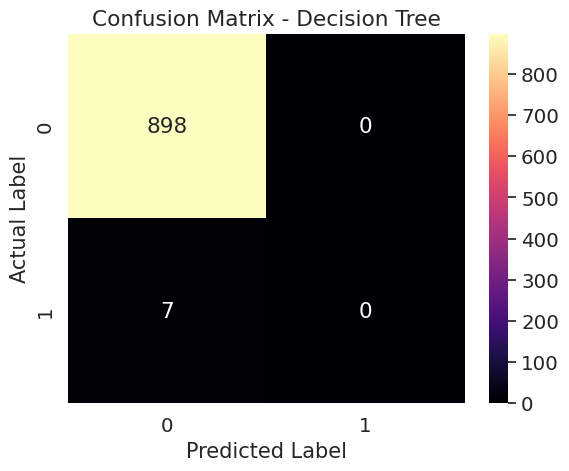

<Figure size 1000x700 with 0 Axes>

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       898
           1       0.00      0.00      0.00         7

    accuracy                           0.99       905
   macro avg       0.50      0.50      0.50       905
weighted avg       0.98      0.99      0.99       905



/uoa/home/u15yl21/sharedscratch/.conda/envs/myJupyter_3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/uoa/home/u15yl21/sharedscratch/.conda/envs/myJupyter_3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/uoa/home/u15yl21/sharedscratch/.conda/envs/myJupyter_3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

X = preprocess(df)
X, le_dict = labelEncoder_get(X)
y = labelList(df.shape[0], [2, 4, 7, 8, 12, 768, 799])

clf = DecisionTreeClassifier()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split_m(X, y, [2, 4, 7, 8, 12, 768, 799])

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

### Original data with generated data
Generated data should only be added into trianing set.

Balanced accuracy score: 0.64


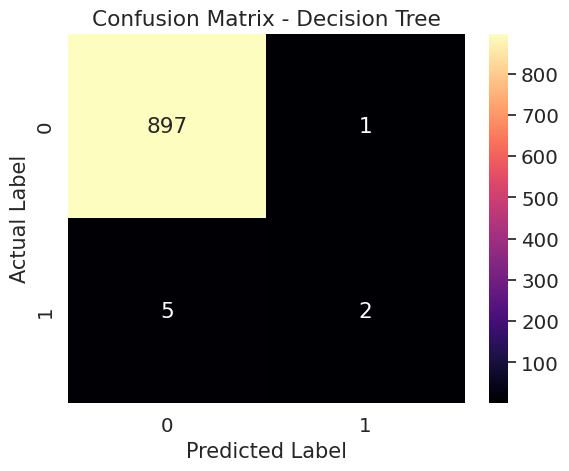

<Figure size 1000x700 with 0 Axes>

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       898
           1       0.67      0.29      0.40         7

    accuracy                           0.99       905
   macro avg       0.83      0.64      0.70       905
weighted avg       0.99      0.99      0.99       905



In [16]:
X_gen = preprocess(gen_data)
X_gen = labelEncoder_trans(X_gen, le_dict)
# add generated data to the original training set
X_train_new = pd.concat([X_train, X_gen], axis=0)


# generated data are all positive
for i in range(len(gen_data)):
    y_train.append(1)

clf.fit(X_train_new, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

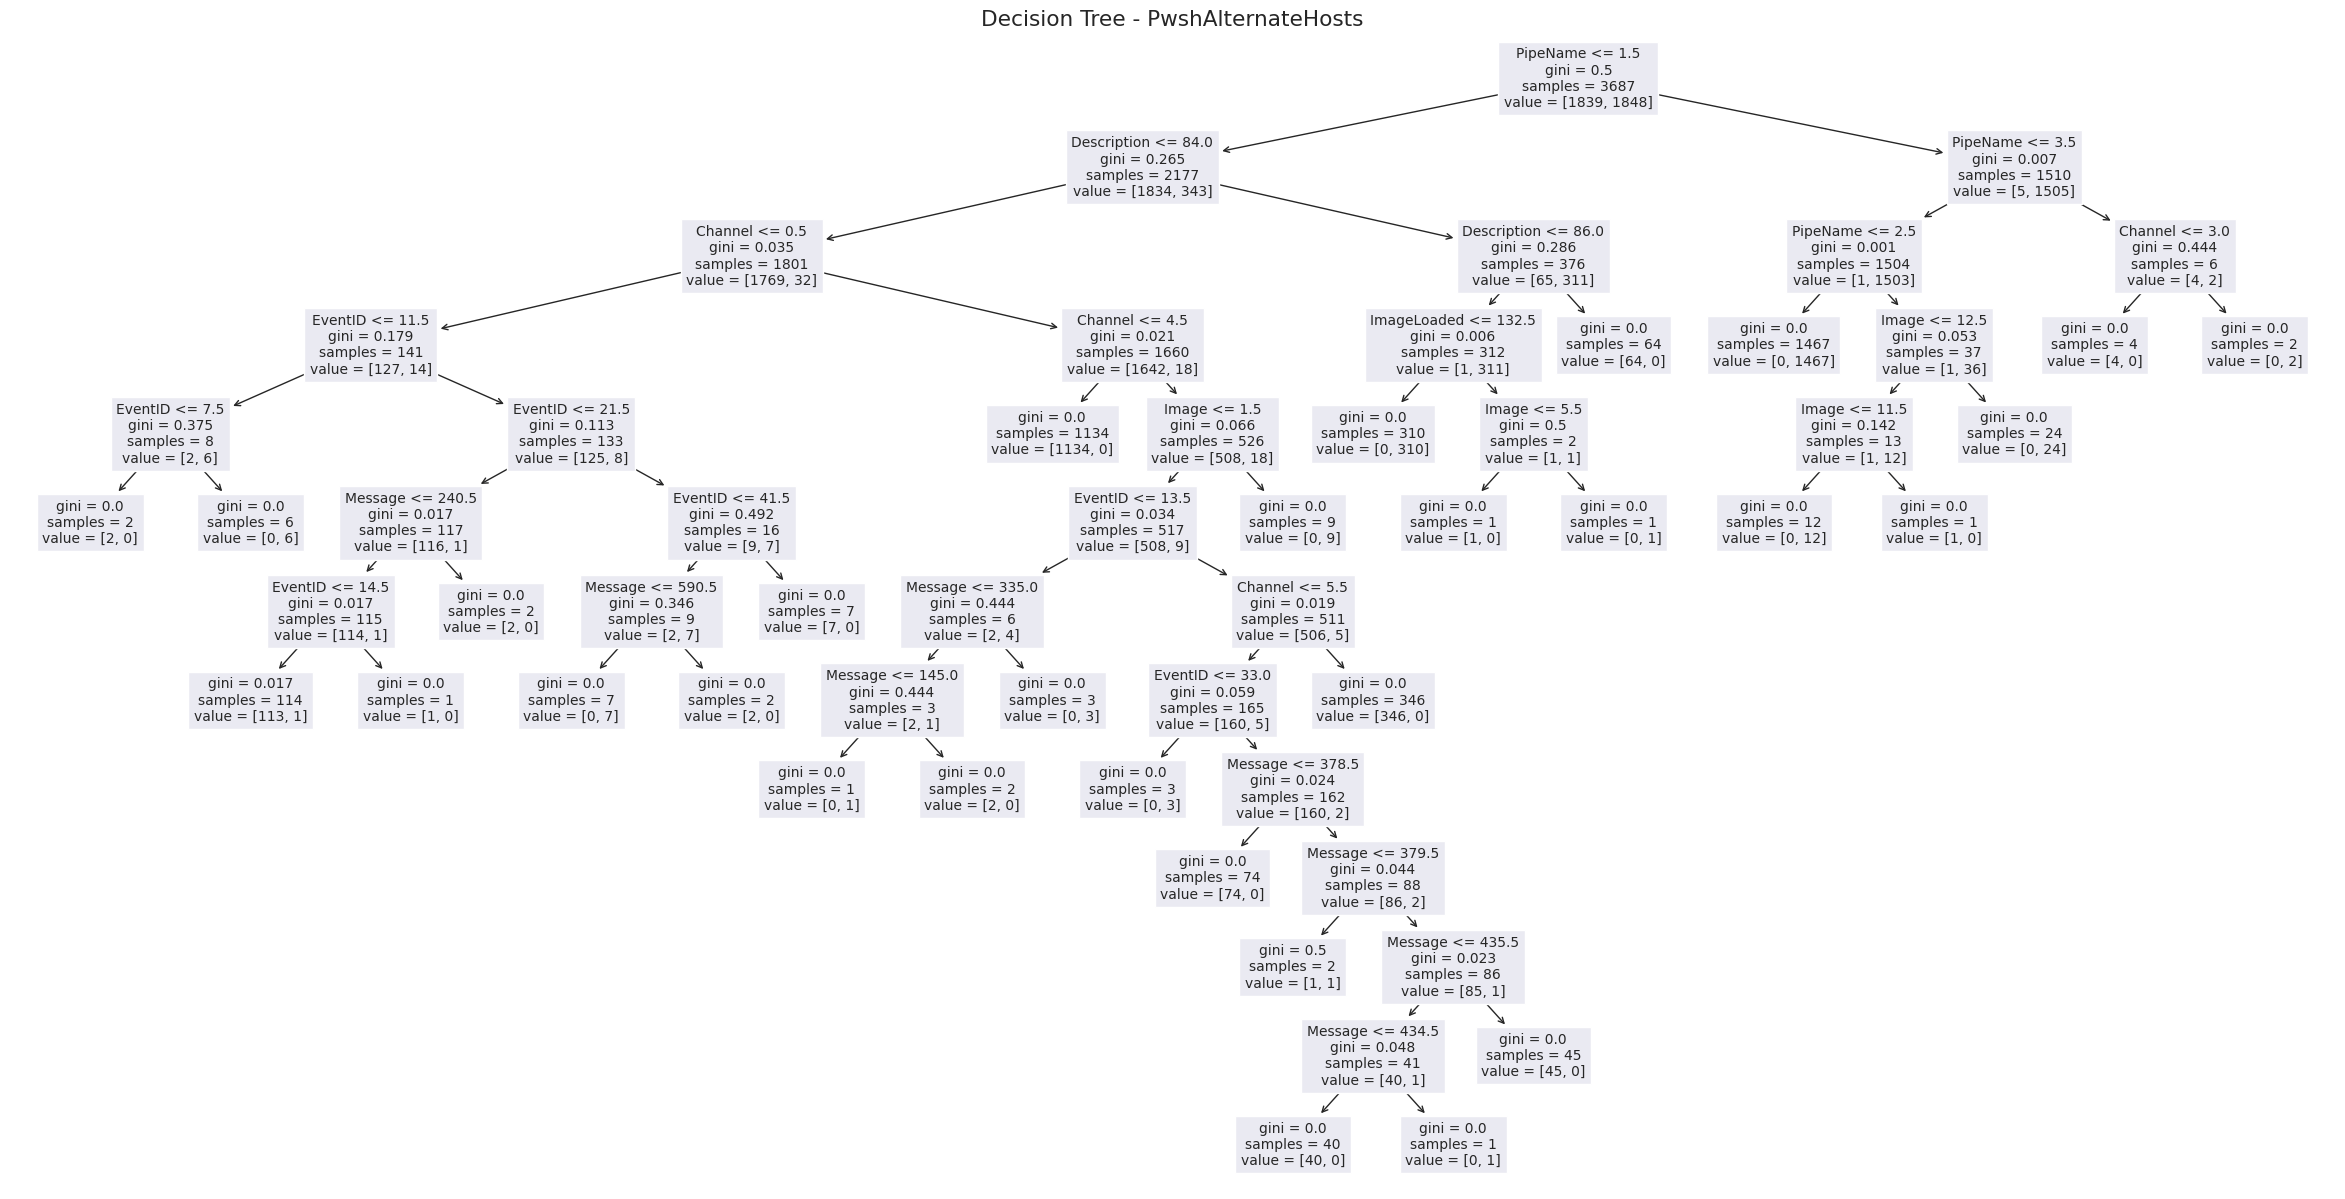

In [19]:
from sklearn import tree
# draw the tree
plt.figure(figsize=(30, 15))
tree.plot_tree(clf, feature_names=features, fontsize=10)
plt.title("Decision Tree - PwshAlternateHosts")
plt.savefig(r'DecisionTree/PwshAlternateHosts.png', dpi=100, transparent=True)

## Save generated data

In [21]:
# # extract to JSON file
# dataset.reset_index(drop=True, inplace=True)
gen_data.to_json(r'generated_datasets/empire_psremoting_stager_new2.json', orient='records')

# dataset = json.read_json(path_or_buf=os.getcwd()+ "\\generated_datasets"+ "\\empire_dllinjection_LoadLibrary_CreateRemoteThread_new.json")
# dataset.head()